In [37]:
# ────────────────────────────────────────────────
# Cell 1: Imports & Setup
# ────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from datetime import datetime

pd.set_option('display.max_columns', 40)
pd.set_option('display.float_format', '{:,.4f}'.format)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('coolwarm')


In [12]:
fg = pd.read_csv('/content/fear_greed_index.csv')
trades = pd.read_csv('/content/historical_data.csv')


In [38]:
print("Fear & Greed shape:", fg.shape)
print("Trades shape:    ", trades.shape)
print("\nFG columns:", fg.columns.tolist())
print("Trades columns:", trades.columns.tolist())
print("\nFG date range:", fg['date'].min(), "→", fg['date'].max())

Fear & Greed shape: (2644, 4)
Trades shape:     (211224, 19)

FG columns: ['date', 'classification', 'value', 'sentiment_score']
Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'ts_dt', 'trade_date', 'ts_ist']

FG date range: 2018-02-01 00:00:00 → 2025-05-02 00:00:00


In [40]:
# ────────────────────────────────────────────────
# Cell 3: Parse Real Timestamp (Timestamp IST)
# ────────────────────────────────────────────────

# Parse the correct timestamp column
trades['ts_ist'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')

# Quality check
print("Timestamp IST parse success rate:", trades['ts_ist'].notna().mean().round(4) * 100, "%")
print("Date range (real trades):", trades['ts_ist'].min(), "→", trades['ts_ist'].max())

trades['trade_date'] = trades['ts_ist'].dt.normalize()

# Drop any parse failures (should be zero)
trades = trades.dropna(subset=['trade_date'])

print("\nUnique trading days:", trades['trade_date'].nunique())

Timestamp IST parse success rate: 100.0 %
Date range (real trades): 2023-05-01 01:06:00 → 2025-05-01 12:13:00

Unique trading days: 480


In [41]:
# ────────────────────────────────────────────────
# Cell 4: Merge Fear & Greed with Trades
# ────────────────────────────────────────────────

fg['date'] = pd.to_datetime(fg['date']).dt.normalize()

df = trades.merge(
    fg[['date', 'value', 'classification']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

# Clean PnL & Fee
df['Closed PnL'] = pd.to_numeric(df['Closed PnL'], errors='coerce').fillna(0)
df['Fee'] = pd.to_numeric(df['Fee'], errors='coerce').fillna(0)
df['net_pnl'] = df['Closed PnL'] + df['Fee']   # fees are negative

print("Merged shape:", df.shape)
print("Rows with sentiment:", df['classification'].notna().sum(), f"({df['classification'].notna().mean():.1%})")
print("\nSentiment distribution:\n", df['classification'].value_counts(dropna=False))

Merged shape: (211224, 23)
Rows with sentiment: 211218 (100.0%)

Sentiment distribution:
 classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
NaN                  6
Name: count, dtype: int64


In [42]:
# ────────────────────────────────────────────────
# Cell 5: Aggregations – Daily & By Sentiment
# ────────────────────────────────────────────────

# Daily level
daily = df.groupby('trade_date').agg(
    total_pnl       = ('net_pnl', 'sum'),
    avg_pnl         = ('net_pnl', 'mean'),
    trade_count     = ('net_pnl', 'count'),
    active_traders  = ('Account', 'nunique'),
    avg_fg_score    = ('value', 'mean'),
    mode_sentiment  = ('classification', lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')
).reset_index()

# By sentiment
sentiment_stats = df.groupby('classification', dropna=False).agg(
    total_pnl       = ('net_pnl', 'sum'),
    avg_pnl         = ('net_pnl', 'mean'),
    median_pnl      = ('net_pnl', 'median'),
    trade_count     = ('net_pnl', 'count'),
    win_rate        = ('net_pnl', lambda x: (x > 0).mean()),
    unique_traders  = ('Account', 'nunique')
).round(3)

print("Daily aggregates (first 8 rows):\n", daily.head(8))
print("\nPerformance by Sentiment:\n", sentiment_stats)

Daily aggregates (first 8 rows):
   trade_date  total_pnl  avg_pnl  trade_count  active_traders  avg_fg_score  \
0 2023-05-01     0.0000   0.0000            3               1       63.0000   
1 2023-12-05    12.5015   1.3891            9               1       75.0000   
2 2023-12-14  -177.1339 -16.1031           11               1       72.0000   
3 2023-12-15   -21.9795 -10.9898            2               1       70.0000   
4 2023-12-16     3.8372   1.2791            3               1       67.0000   
5 2023-12-17   334.0523  23.8609           14               1       73.0000   
6 2023-12-18     7.7910   3.8955            2               1       65.0000   
7 2023-12-19 1,023.4392  68.2293           15               1       73.0000   

  mode_sentiment  
0          Greed  
1  Extreme Greed  
2          Greed  
3          Greed  
4          Greed  
5          Greed  
6          Greed  
7          Greed  

Performance by Sentiment:
                     total_pnl    avg_pnl  median_pnl  t

In [43]:
# ────────────────────────────────────────────────
# Cell 6: Statistical Test (ANOVA)
# ────────────────────────────────────────────────

valid_groups = [df[df['classification'] == cat]['net_pnl'].dropna()
                for cat in sentiment_stats.index if cat != 'NaN' and len(df[df['classification'] == cat]) > 5]

if len(valid_groups) >= 2:
    f_stat, p_val = f_oneway(*valid_groups)
    print(f"ANOVA test – PnL differences across sentiment categories")
    print(f"F-statistic: {f_stat:.2f} | p-value: {p_val:.6f}")
    if p_val < 0.05:
        print("→ Statistically significant differences (p < 0.05)")
    else:
        print("→ No strong statistical evidence of differences")
else:
    print("Not enough groups for ANOVA")

ANOVA test – PnL differences across sentiment categories
F-statistic: 8.93 | p-value: 0.000000
→ Statistically significant differences (p < 0.05)


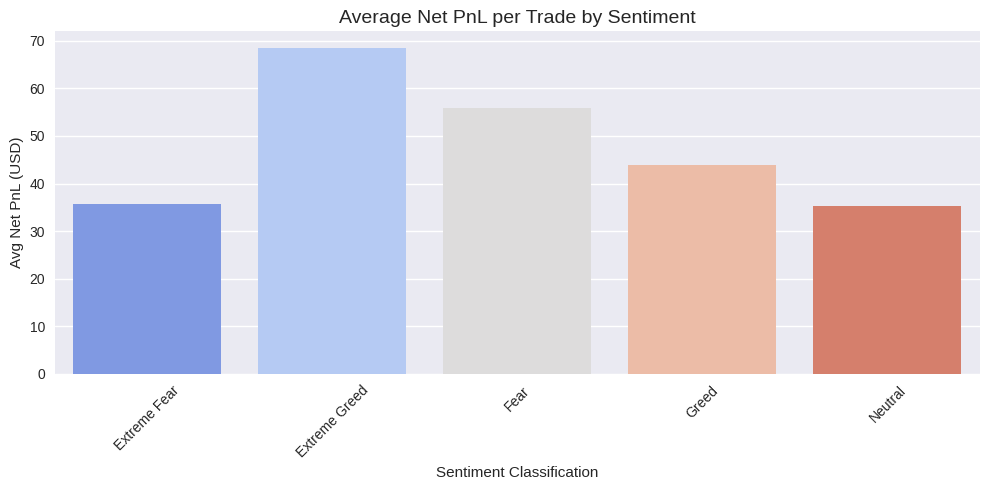

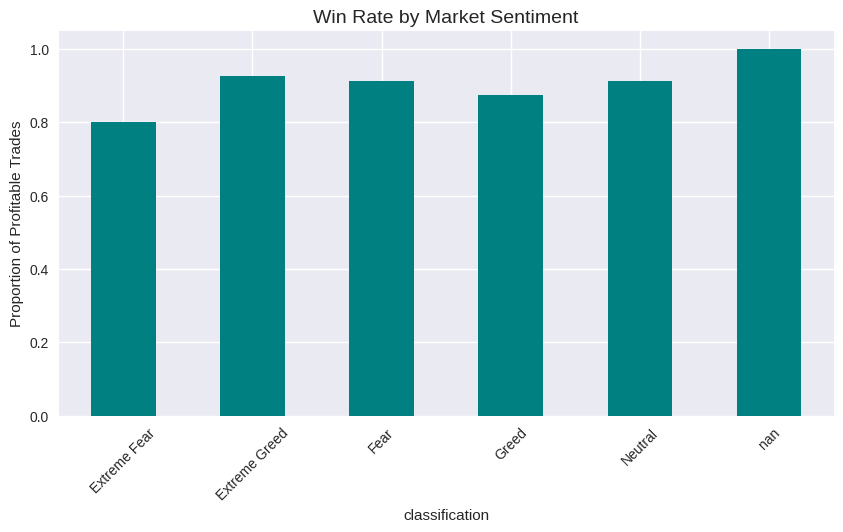

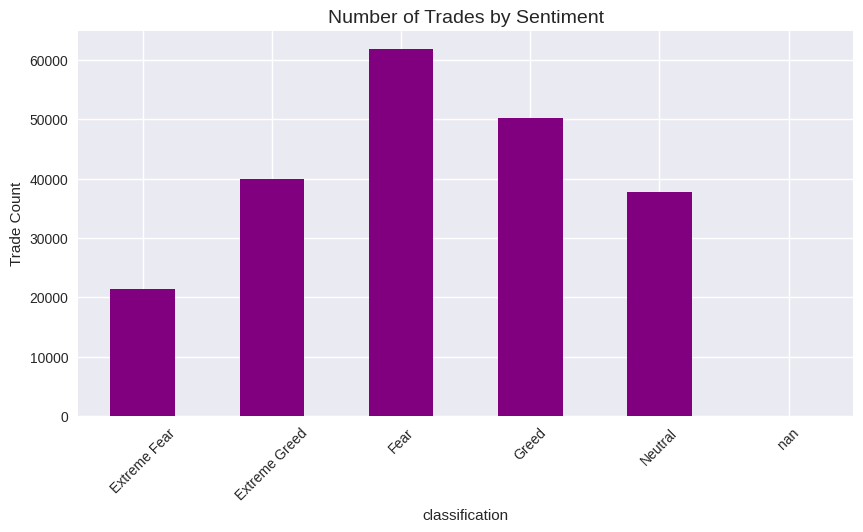

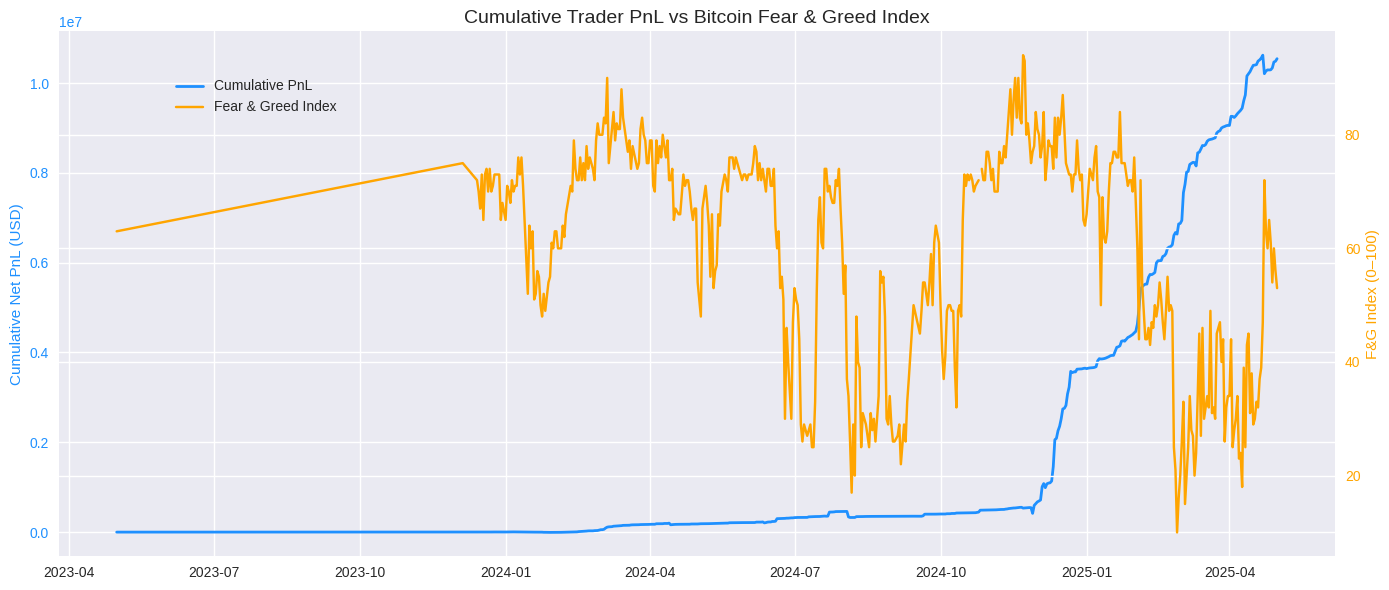

In [44]:
# ────────────────────────────────────────────────
# Cell 7: Visualizations
# ────────────────────────────────────────────────

# 1. Avg PnL per trade by sentiment
plt.figure(figsize=(10, 5))
sns.barplot(
    x=sentiment_stats.index,
    y=sentiment_stats['avg_pnl'],
    hue=sentiment_stats.index,
    palette='coolwarm',
    legend=False
)
plt.title("Average Net PnL per Trade by Sentiment", fontsize=14)
plt.ylabel("Avg Net PnL (USD)")
plt.xlabel("Sentiment Classification")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Win rate by sentiment
plt.figure(figsize=(10, 5))
sentiment_stats['win_rate'].plot(kind='bar', color='teal')
plt.title("Win Rate by Market Sentiment", fontsize=14)
plt.ylabel("Proportion of Profitable Trades")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.show()

# 3. Trade volume by sentiment
plt.figure(figsize=(10, 5))
sentiment_stats['trade_count'].plot(kind='bar', color='purple')
plt.title("Number of Trades by Sentiment", fontsize=14)
plt.ylabel("Trade Count")
plt.xticks(rotation=45)
plt.show()

# 4. Cumulative PnL vs Fear & Greed
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(daily['trade_date'], daily['total_pnl'].cumsum(), color='dodgerblue', linewidth=2, label='Cumulative PnL')
ax1.set_ylabel('Cumulative Net PnL (USD)', color='dodgerblue')
ax1.tick_params(axis='y', labelcolor='dodgerblue')

ax2 = ax1.twinx()
ax2.plot(daily['trade_date'], daily['avg_fg_score'], color='orange', label='Fear & Greed Index')
ax2.set_ylabel('F&G Index (0–100)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Cumulative Trader PnL vs Bitcoin Fear & Greed Index", fontsize=14)
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88))
plt.tight_layout()
plt.show()

In [46]:
# ────────────────────────────────────────────────
# Cell 8: Top / Bottom Traders (regardless of sentiment)
# ────────────────────────────────────────────────

trader_summary = df.groupby('Account').agg(
    total_net_pnl   = ('net_pnl', 'sum'),
    trade_count     = ('net_pnl', 'count'),
    win_rate        = ('net_pnl', lambda x: (x > 0).mean()),
    avg_fg_traded   = ('value', 'mean')
).sort_values('total_net_pnl', ascending=False).round(2)

print("Top 10 Traders by Total Net PnL:\n", trader_summary.head(10))
print("\nBottom 5 Traders:\n", trader_summary.tail(5))

Top 10 Traders by Total Net PnL:
                                             total_net_pnl  trade_count  \
Account                                                                  
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23 2,159,377.9200        14733   
0x083384f897ee0f19899168e3b1bec365f52a9012 1,607,635.1300         3818   
0xbaaaf6571ab7d571043ff1e313a9609a10637864   948,760.5100        21192   
0x513b8629fe877bb581bf244e326a047b249c4ff1   916,847.2000        12236   
0xbee1707d6b44d4d52bfe19e41f8a828645437aab   849,433.4500        40184   
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4   685,773.0400         4356   
0x72743ae2822edd658c0c50608fd7c5c501b2afbd   430,907.0000         1590   
0x430f09841d65beb3f27765503d0f850b8bce7713   417,288.8800         1237   
0x72c6a4624e1dffa724e6d00d64ceae698af892a0   403,301.5200         1430   
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4   381,690.6700         9893   

                                            win_rate  avg_fg_traded  
Account